In [1]:
file_path="E:/python/数据分析语言基础/大作业/脚本和notebook/"
import pandas as pd
import numpy as np
from 处理文件 import Process_data
import matplotlib.pyplot as plt
plt.style.use("seaborn")
plt.rcParams['font.sans-serif']=['SimHei']   # 用黑体显示中文
plt.rcParams['axes.unicode_minus']=False  
import time
print("运行过程具有随机性，可能无法找到和论文中找到的完全一致的房东")
time.sleep(0.5)
plt.style.use("seaborn")
def clear_output():
    """
    clear output for both jupyter notebook and the console
    """
    import os
    os.system('cls' if os.name == 'nt' else 'clear')
    if is_in_notebook():
        from IPython.display import clear_output as clear
        clear()
def is_in_notebook():
    import sys
    return 'ipykernel' in sys.modules



运行过程具有随机性，可能无法找到和论文中找到的完全一致的房东


In [2]:
# 进行聚类，寻找潜在的价格可能没有达到较大收益的
res=Process_data(file_path+"Beijing-result-2021-10-26.csv",with_scale=True)
X_columns=res["X_columns"]
X_train,X_test,y_train,y_test=res["X_train"],res["X_test"],res["y_train"],res["y_test"]

# 寻找columns里面的含有的这几个重点区域的 X_columns的索引
columns=["neighbourhood_cleansed0","neighbourhood_cleansed4","neighbourhood_cleansed6","neighbourhood_cleansed7"]
icolumns=[]
for i,X_column in enumerate(X_columns):
    for j,column in enumerate(columns):
        if X_column==column:
            icolumns.append(i)
# 把X,y合并成一个dataframe
data=pd.DataFrame(np.append(np.append(y_train,y_test,axis=0).reshape(len(y_train)+len(y_test),1),np.append(X_train,X_test,axis=0),axis=1),columns=np.append("notavailable",X_columns))




正在处理: E:/python/数据分析语言基础/大作业/脚本和notebook/Beijing-result-2021-10-26.csv
 正在删除强相关变量...
  删除前: (19675, 123)
 删除完成 (19675, 118)
请核对训练集，测试集形状:
X_train.shape: (14756, 116)
y_train.shape: (14756,)
X_test.shape: (4919, 116)
y_test.shape: (4919,)


 * 总体来说，应该按照calender进行计算，把如下公式作为房东$x$满意收益：
     $$Adjusted\_price_x \cdot not\_available_x-\frac{\sum_{i}{Adjust\_price_{i,j}\cdot \mathbf{1}}}{\sum_{i}1}$$

In [3]:
# 计算各个区域中经济效益，计算公式如上所述，“deviation”高的变量说明经济效率高：定价也高，预订率也高。
data["deviation"]=0
for column in columns:
    temp=data.groupby(column,as_index=False)[["adjusted_price","notavailable"]].mean()
    if temp.loc[0,column]>temp.loc[1,column]:
        i=0
        data.loc[data.loc[:,column]==temp.loc[i,column],"deviation"]=np.exp(data.loc[data.loc[:,column]==temp.loc[i,column],"adjusted_price"]*res["scale"][0]+res["mean"][0])*data.loc[data.loc[:,column]==temp.loc[i,column],"notavailable"]-np.exp(temp.loc[i,"adjusted_price"]*res["scale"][0]+res["mean"][0])*temp.loc[i,"notavailable"]
    else:
        i=1
        data.loc[data.loc[:,column]==temp.loc[i,column],"deviation"]=np.exp(data.loc[data.loc[:,column]==temp.loc[i,column],"adjusted_price"]*res["scale"][0]+res["mean"][0])*data.loc[data.loc[:,column]==temp.loc[i,column],"notavailable"]-np.exp(temp.loc[i,"adjusted_price"]*res["scale"][0]+res["mean"][0])*temp.loc[i,"notavailable"]
        



In [4]:
print("展示一部分效益不好的房源...")
print(data.sort_values(by="deviation",ascending=True,kind="stable").head(20).loc[:,["notavailable","adjusted_price","deviation"]])#.loc[:,columns]


展示一部分效益不好的房源...
     notavailable  adjusted_price   deviation
31            0.0        1.036507 -893.868323
76            0.0        0.965964 -893.868323
145           0.0        0.832846 -893.868323
175           0.0        1.521585 -893.868323
186           0.0        1.936259 -893.868323
197           0.0        1.093696 -893.868323
282           0.0        1.386682 -893.868323
316           0.0        0.367479 -893.868323
349           0.0        1.219165 -893.868323
427           0.0        1.699081 -893.868323
632           0.0        0.717296 -893.868323
633           0.0        0.989812 -893.868323
680           0.0        0.514285 -893.868323
699           0.0        0.674216 -893.868323
811           0.0        1.394647 -893.868323
824           0.0        0.790104 -893.868323
830           0.0       -0.014939 -893.868323
874           0.0        1.033997 -893.868323
902           0.0        0.951573 -893.868323
942           0.0        2.056961 -893.868323


In [5]:
# 把训练集和测试集合并起来训练模型，假定MSE还是3.数据学习中在测试集上的表现
mse=0.09
X=data.loc[:,"adjusted_price":]
y=data.loc[:,"notavailable"]
from lightgbm import LGBMRegressor
clf=LGBMRegressor()
params_LGBM=np.load(file_path+"LGBMbest_params.npy",allow_pickle=True).item()
clf.set_params(**params_LGBM)
clf.fit(X,y)


LGBMRegressor(learning_rate=0.042042151566098876, max_depth=0, n_estimators=160,
              num_leaves=110, random_state=0)

In [6]:
plt.style.use("seaborn")
plt.rcParams['font.sans-serif']=['SimHei']   # 用黑体显示中文
plt.rcParams['axes.unicode_minus']=False  
def Generate_price(item:int):
    """生成一系列数据，数据的取值范围从最低价格一直到最高价格，用来检测这个房源的降价空间。给出一个序号，返回的是一个生成的X_ge"""
    X_gen=data.loc[item,"adjusted_price":].to_numpy().reshape(1,-1)
    price_range=np.linspace(np.min(data["adjusted_price"]),np.max(data["adjusted_price"]),2**9)
    for i in range(9):
        X_gen=np.append(X_gen,X_gen,axis=0)
    X_gen[:,0]=price_range
    return X_gen

def Price(X_gen):
    """标准化价格"""
    return np.exp(X_gen[:,0]*res["scale"][0]+res["mean"][0])

def Show_picture(i):
    # 生成y_pred,绘制y_pred图片
    X_gen=Generate_price(i)
    y_pred=clf.predict(X_gen)
    y_pred_up=y_pred*(1+mse);
    y_pred_down=y_pred*(1-mse);
    y_pred[y_pred>=1]=1
    y_pred[y_pred<=0]=0
    y_pred_down[y_pred_down>1]=1
    y_pred_down[y_pred_down<0]=0
    y_pred_up[y_pred_up>1]=1
    y_pred_up[y_pred_up<0]=0    
    fig=plt.figure(figsize=(6,10))
    ax=plt.subplot(2,1,1)
    ax.fill_between(Price(X_gen), y_pred_down,y_pred_up,alpha=0.2,color='gold')
    plt.plot(Price(X_gen),y_pred,alpha=1)
    plt.scatter(np.exp(data.loc[i,"adjusted_price"]*res["scale"][0]+res["mean"][0]),data.loc[i,"notavailable"],s=30,c="red",cmap="rocket",label="实际值")
    plt.title(str(i)+"号房源预订率-价格曲线")
    plt.xlabel("房源价格")
    plt.ylabel("预订率")
    plt.legend();
    
    ax=plt.subplot(2,1,2)
    Reve=Price(X_gen)*y_pred
    Reve_down=Price(X_gen)*y_pred_down
    Reve_up=Price(X_gen)*y_pred_up
    ax.fill_between(Price(X_gen),Reve_down,Reve_up,alpha=0.2,color='gold')
    plt.plot(Price(X_gen),Reve)
    revenue=np.exp(data.loc[i,"adjusted_price"]*res["scale"][0]+res["mean"][0])*data.loc[i,"notavailable"]
    plt.scatter(np.exp(data.loc[i,"adjusted_price"]*res["scale"][0]+res["mean"][0]),revenue,s=30,c="red",cmap="rocket",label="实际值")
    plt.title(str(i)+"号房源收入-价格曲线")
    plt.xlabel("房源价格")
    plt.ylabel("收入")    
    plt.legend();
    plt.show();
    print("现在价格：")
    print(np.exp(data.loc[i,"adjusted_price"]*res["scale"][0]+res["mean"][0]))
    print("偏差：")
    print(data.loc[i,"deviation"])



 ## 普通房源

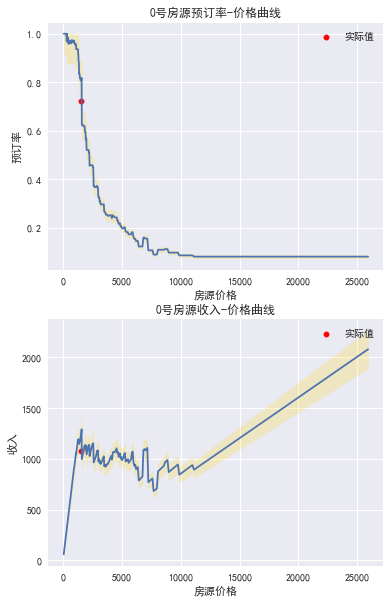

现在价格：
1501.0000009999999
偏差：
609.6517332117877


In [7]:
Show_picture(0)


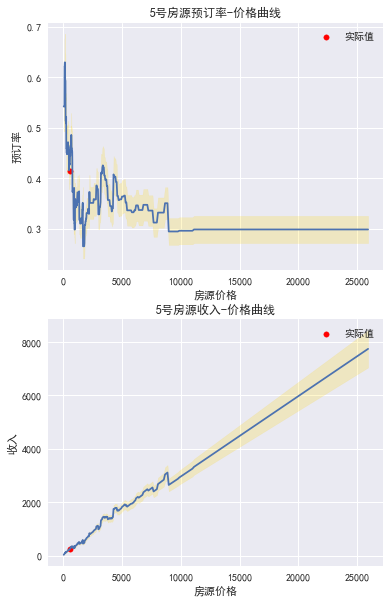

现在价格：
558.000001
偏差：
0.0


In [8]:
Show_picture(5)


 ## 低收益率房源

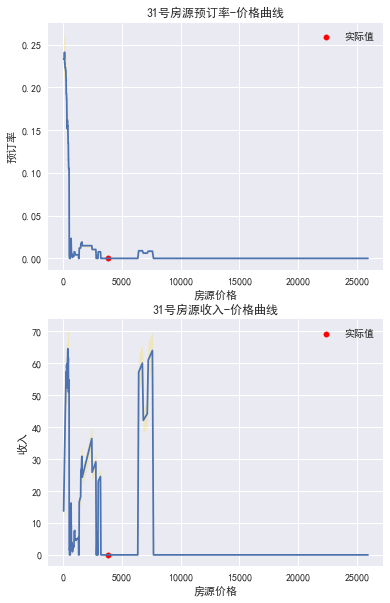

现在价格：
3789.0000010000026
偏差：
-893.8683233918055


In [9]:
Show_picture(31)


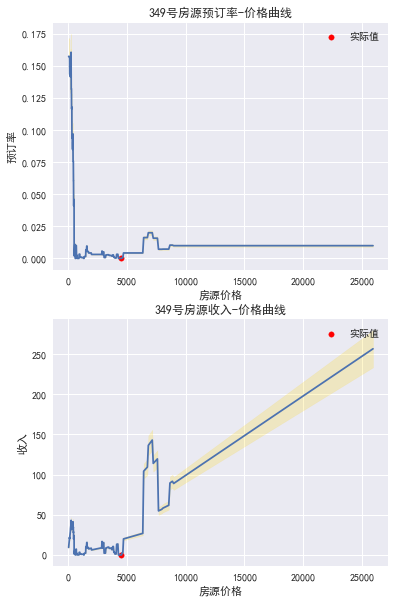

现在价格：
4505.000001000002
偏差：
-893.8683233918055


In [10]:
Show_picture(349)


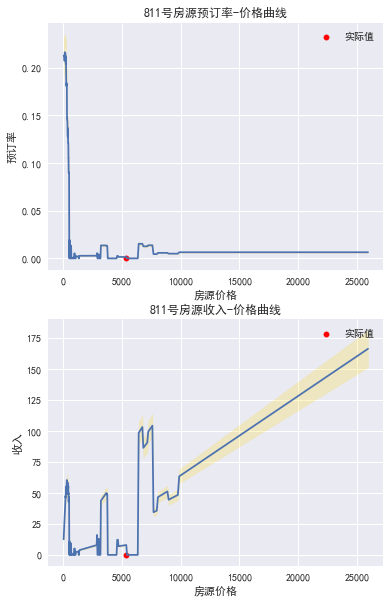

现在价格：
5320.000001
偏差：
-893.8683233918055


In [11]:
Show_picture(811)


In [12]:
# 保留的这段注释掉的代码可以用来画着玩...这是当时笔者探索用到的代码
# for i in data.sort_values(by="deviation",ascending=True,kind="stable").index:#np.arange(0,1000):
#     Show_picture(i)

#     is_stop=input("输入任何字符结束：")
#     if is_stop:
#         break
#     else:
#         clear_output()
    


